# Digging into farris_bot

In [4]:
import numpy as np

from numpy import array, linspace, exp, pi, sqrt
from random import randint, choice
import matplotlib.pyplot as plt
import os.path


## Common parameters

In [5]:
seed = randint(0,2**20)
use_complex = choice([True, False])
symm = choice([3,3,3,4,5,5,5,5,5,5,5,7,7,9])

do_complex = 1
do_complex = 0
steps = 2
dec = .3
fpp = 20

## Rewrite first

This is my rewrite using broadcasting and multipilcation of tensors.

- always put np. explicitly because then I know it's tensor math
- notation for broadcasting the **thetas** is non intuitive but...
- **phases** is a tensor with the same dimensions as **thetas**

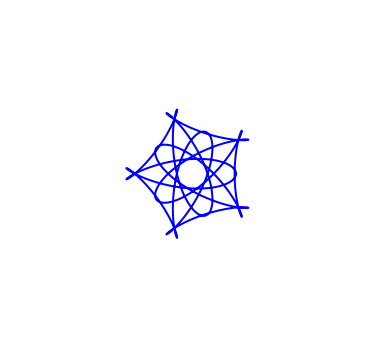

In [49]:
def decay(s):
    return 1/(abs(s) + 0.5)**dec

decay = np.vectorize(decay)

tics = np.arange(-steps,steps)*symm + 1
decay_v = decay(tics)

#unpack to named variables
a,b,c = [ np.random.normal(size=len(tics))*decay_v for  i in range(3)]

#I can have do_complex as a boolean now
if do_complex == 1:
    for z in a,b:
        z += 1J*np.random.normal(size=len(tics))*decay_v
    c  = b.conjugate()
    
#make theta broadcastable
theta = np.linspace(0,2*np.pi,500)
theta = theta[:, None] + 0*tics
phases = np.exp( 1J*tics*theta )

#bounding box ?
maxzs = max([np.linalg.norm( (z_v*phases).sum(axis=1)) for z_v in [a,b,c]])**.5
frame = np.ceil(4*maxzs)/5
axshape = [-frame, frame, -frame, frame]
fig = plt.figure(figsize=(6,6))
                     
for i,t in enumerate(linspace(0,1,fpp)):
    #tensor calculation
    zs = ( (1-t)*c + t*a*phases).sum(axis=1)
    plt.cla()
    plt.plot(zs.real, zs.imag, 'b', lw=2)
    plt.axis('square')
    plt.axis('off')
    plt.axis(axshape)
    #savefig(os.path.join('./', "frame{:03}.{}".format(2*fpp+i, 'png')), bbox_inches='tight')



## "Old" version

This has less LOC principally because the heavy lifting to 
do the initialization of coeff\d is done above

In [ ]:
#hash these - I think they come from matplotlib.pylab

norm = np.linalg.norm
ceil = np.ceil

#I vectorized this so redfine it
def decay(s):
    return 1/(abs(s*symm+1)+0.5)**dec

coeff0 = dict([* zip(tics, a)])
coeff1 = dict([* zip(tics, b)])
coeff2 = dict([* zip(tics, c)])

theta = linspace(0,2*pi,500)
maxzs = max([sqrt(norm(array([coeff0[j]*exp(complex(0,1)*j*theta) for j in coeff]).sum(axis=0)))
             for coeff in [coeff0, coeff1, coeff2]])

frame = ceil(4*maxzs)/5
axshape = [-frame, frame, -frame, frame]

plt.figure(figsize=(6,6))

for i,t in enumerate(linspace(0,1,fpp)):
    zs = array([((1-t)*coeff2[j]+t*coeff0[j])*exp(complex(0,1)*j*theta) for j in coeff0]).sum(axis=0)
    plt.cla()
    plt.plot(zs.real, zs.imag, 'b', lw=2)
    plt.axis('square')
    plt.axis('off')
    plt.axis(axshape)
    #savefig(os.path.join('./', "frame{:03}.{}".format(2*fpp+i, 'png')), bbox_inches='tight')

    

## Makes a video of the homotopy

I altered the code to make a homotopy.
Is that what it's supposed to do?

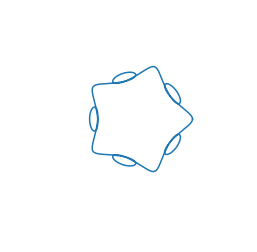

In [48]:
import matplotlib

symm = choice([3,3,3,4,5,5,5,5,5,5,5,7,7,9])

def decay(s):
    return 1/(abs(s) + 0.5)**dec

decay = np.vectorize(decay)

tics = np.arange(-steps,steps)*symm + 1
decay_v = decay(tics)

#unpack to named variables
a,b,c = [ np.random.normal(size=len(tics))*decay_v for  i in range(3)]

#I can have do_complex as a boolean now
if do_complex == 1:
    for z in a,b:
        z += 1J*np.random.normal(size=len(tics))*decay_v
    c  = b.conjugate()
    
#make theta broadcastable
theta = np.linspace(0,2*np.pi,500)
theta = theta[:, None] + 0*tics
phases = np.exp( 1J*tics*theta )

#bounding box ?
maxzs = max([np.linalg.norm( (z_v*phases).sum(axis=1)) for z_v in [a,b,c]])**.5
frame = np.ceil(4*maxzs)/5
axshape = [-frame, frame, -frame, frame]

fig, ax = plt.subplots()
ax.axis(axshape)
ax.axis('square')
ax.axis('off')
ax.axis(axshape)
l, = ax.plot([],[])

num_frames = 40

def animate(t):
    t = abs(t - num_frames/2)/(num_frames/2)
    vv = (1-t)*a + t*b
    zs = (vv*phases).sum(axis=1)
    zs -= sum(zs)/len(zs)
    zs *= 1.5
    
    
    #zs = (np.cos(t*np.pi/10) + 1J*np.sin(t*np.pi/10))*np.array([-1,1])
    l.set_data(zs.real, zs.imag)
                     

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=num_frames)

from IPython.display import HTML
#HTML(ani.to_jshtml())
HTML(ani.to_html5_video())
